# Review Genie - A conversation Chatbot for an E-Commerce Application

# Overview of Week 1

Key Objectives - In the first week of Review Genie, our goals are as follows:

- Understanding the overall business problem
- Identifying the key milestones that we have to close
- Understand the apply the key tools that we need here
- Building a simple POC app, that will set the groundwork for the subsequent weeks.



**Structure of this Notebook**

- Basics of RAG.
  - The Need for RAG
  - Basic RAG app architecture
  - Tools for building the RAG app
- Building ReviewGenie POC
  - Data Preparation
  - Vector Store Setup
  - Building the chatbot
  - Building a simple Gradio UI


## Basics of RAG

Before we start coding, lets go over a few questions and get it clarified.

### 1. What is RAG?
Imagine you're writing an article about climate change, but instead of relying only on what you remember, you search online for recent studies and data to support your writing. RAG works the same way—it combines a powerful AI language model with a search system that retrieves relevant information from an external knowledge source, like a database or documents. This helps generate more accurate and informative responses.

### 2. Why is RAG important?
RAG is crucial because AI models, like ChatGPT, can sometimes "hallucinate" or provide outdated or incorrect information. By retrieving facts from trusted sources before generating responses, RAG ensures the answers are more reliable, up-to-date, and contextually relevant.

### 3. What’s the difference between RAG and a standard AI chatbot?
A standard chatbot relies only on pre-trained knowledge, which may be limited or outdated. RAG-enhanced chatbots, however, actively retrieve fresh, relevant information from external sources, ensuring better accuracy and up-to-date insights.

### 4. What are the key components of RAG?
RAG consists of two main parts:

- Retriever: Finds the most relevant documents or data from a knowledge base (e.g., a search engine or database).
- Generator: Uses the retrieved information to produce a coherent and accurate response.

### 5. Usecases in real-life
- Customer Support: AI chatbots retrieve knowledge base articles to provide better responses to customer queries.
- Healthcare: Doctors can get AI-assisted summaries of patient records and the latest medical research.
- Legal Services: Lawyers can search through legal documents and case studies to build stronger cases.

### Understanding the Limitation of the LLM

In [1]:
# Importing the OpenAI library to interact with OpenAI's API services.
from openai import OpenAI

In [2]:
import os  # Importing the os module to interact with environment variables
import getpass  # Importing getpass to securely input sensitive information

# Prompting the user to securely enter their OpenAI API key without displaying it on the screen
OPENAI_API_KEY = getpass.getpass("Enter your OpenAI API key: ")

Enter your OpenAI API key: ··········


In [3]:
# Creating an instance of the OpenAI client using the provided API key.
client = OpenAI(api_key=OPENAI_API_KEY)

In [10]:
# Defining the prompt to query the LLM
prompt = ''' What was uber's revenue in 2022? '''

In [11]:
# Sending a request to the OpenAI API to generate a chat response
openai_response = client.chat.completions.create(
    model='gpt-3.5-turbo',  # Specifying the model to use;
    # Note: An older model chosen for testing purposes because the cutoff is 2021 whereas prompt is querying details about 2022
    messages=[{'role': 'user', 'content': prompt}]  # Creating a structured message for the AI model
)


In the above code, while creating a structured message for the AI model,  `role `defines the speaker (user input) and `content` contains the actual query stored in the `prompt` variable.

We are structuring the input this way because OpenAI's chat models require a specific format to understand and process conversations effectively. Assigning roles like 'user' helps the AI distinguish between different participants in the conversation, ensuring it provides relevant and context-aware responses.

In [12]:
# Accessing the generated response from the AI model.
openai_response.choices[0].message.content
# Note:'choices' contains multiple response options, we take the first one ([0]),
# 'message' holds the response details, and 'content' extracts the actual text generated by the AI.

"As an AI, I cannot provide real-time data. I recommend checking the latest financial reports or visiting Uber's official website for the most up-to-date information on their revenue for 2022."

### Interpretation:
Why is the LLM not able to answer the query?

`gpt-3.5-turbo` does not have access to data after 2021 because of its cutoff.

#### Do it yourself:
Try changing the model to `gpt-4o-mini` and observe how the output changes!

As you can see above, the LLM we used(gpt 3.5) doesn't have access to the latest data. Now as LLMs get updated, the training cut-off date may or may not have access to more information. However, it's always a good idea to understand how to improve the context of our prompt

### Making the LLM context-aware

Next Step: Let's check Uber's [financial report ](https://s23.q4cdn.com/407969754/files/doc_events/2024/May/06/2023-annual-report.pdf)

On Page 54, of the above document it states:

"Revenue was 37.3 billion, up 17% year-over-year. Mobility revenue increased 5.8 billion primarily attributable to an increase in
Mobility Gross Bookings of......"

In [14]:
## Let's create the above context for the prompt
# Defining a context string with revenue details retrieved from an external source.
retrieved_context = '''Revenue was $37.3 billion, up 17% year-over-year. Mobility revenue increased $5.8 billion primarily attributable to an increase in
               Mobility Gross Bookings of 31% year-over-year.'''

In [15]:
## Let's modify our prompt now
# Creating a prompt by embedding the retrieved context into a question for the AI model.

prompt = f"What was Uber's revenue in 2022? Check in {retrieved_context}"

# Note: The AI is being asked to analyze the given context and provide Uber's revenue for 2022

In [16]:
## Let's ask the LLM again
openai_response = client.chat.completions.create(
    model = 'gpt-3.5-turbo',
    messages = [{'role': 'user', 'content': prompt}])

In [17]:
# Accessing the generated response from the AI model.
openai_response.choices[0].message.content

"Uber's revenue in 2022 was $37.3 billion."

### Interpretation:
How is the LLM able to answer the same question now?

The LLM can now answer the question accurately because the relevant financial data is explicitly provided in the `retrieved_context`, allowing the model to reference it directly instead of relying on its pre-trained knowledge.

As you saw in the example above, we

- **retrieved** the context from an external source
- **augmented** our prompt that passes to the LLM, and
- **generated** the response

This is Retrieval Augmented Generation in a nutshell!

### Basic RAG app architecture

In the previous example, we ***manually*** retrieved the context from the given file which for all purposes is impractical!

Therefore, we have to devise a strategy that enables us to:

- Take the query from the user
- Identify the documents from the external source that might be relevant for the query.
- Pass those documents' information as context to the LLM
- LLM then generates the final response

To do the above, we can follow a simple standard architecture as shown below (Image source - https://huyenchip.com/2024/07/25/genai-platform.html)

<center><img src="https://huyenchip.com/assets/pics/genai-platform/3-rag.png" width=500 height=400/></center>

As you can see in the above image, the retriever would be the key component of this entire architecture.

To build the retriever, we have to follow these steps:

- Connect to the document source
- Break the documents down to manageable chunks.
   - This is due to the fact that taking in the entire document source for building the context will exceed the token limits of the LLM.
   - This process is also called **Chunking**.
- Perform a search for the most relevant chunks based on the given query.
- Pass those relevant chunks to the LLM.

For performing the search or retrieval process, we will be following an **embedding-based approach.**

<center><img src="https://cdn.prod.website-files.com/640248e1fd70b63c09bd3d09/653fd23f1565c0c1da063efc_Semantic%20Search%20Text%20Embeddings%20(1).png" width =500/></center>

### Understanding Embedding based approach

In the embedding based approach:

- We convert the document chunks in the database to vector embeddings and store it in a vector store.

- Convert the given user query to an embedding.

- Find the document chunks whose vector embeddings are closest to the given query embedding using a vector search algorithm like FAISS (Facebook AI Similarity Search)

<center><img src="https://miro.medium.com/v2/resize:fit:1400/1*h_btyitJX79d-gFE8RaMQg.png" width=500/></center>

### Tools for building the RAG App

Now that we are familiar with the overall architecture, we can now go ahead and structure the tools that we'll use for the upcoming demonstration:

- OpenAI LLM (model - GPT 4o-mini): This will be our primary model for generating the responses
- LangChain: Langchain is a powerful framework for orchestrating different layers in the RAG app. We shall use this to build the retriever end-to-end and also connect with other tools for tasks such as
    - Chunking - RecursiveCharacterTextSplitter
    - Embedding Model - OpenAIEmbeddings
    - Vector Search Model - FAISS
- Gradio: This will help in building a simple UI at the end.

## Building ReviewGenie POC

*A basic chatbot that can answer customer queries*

## Problem Statement
Shopping online can be overwhelming. You search for a simple pair of shoes, but end up scrolling through countless options—many irrelevant, some too expensive, others just not right. Traditional search engines rely on keywords, often missing what you truly need.

Let's build an AI-powered product discovery chatbot changes this. Using advanced language models and vector-based search, it goes beyond keywords to understand your intent, offering personalized, context-aware recommendations in seconds.

<center><img src="https://www.pranathiss.com/static/assets/images/ai-powered-chatBot.webp" width=500/></center>

This smart solution enhances the shopping experience, increasing customer satisfaction, engagement, and conversions. The future of e-commerce is here—smarter, intuitive, and built for you.



### Dataset Used:
The given dataset contains information about various products, including their IDs, descriptions, and specifications. Below is a detailed description of each column and the type of data it contains.

You can download the entire dataset [here](https://www.kaggle.com/datasets/piyushjain16/amazon-product-data).
Or you can download the smaller sample dataset [here](https://drive.google.com/file/d/1ohd9xo19HmDVIwpXPf_IyMkwr29gJJxR/view?usp=drive_link).

#### Column Descriptions:
- `PRODUCT_ID (Integer)`
A unique identifier assigned to each product.
Example: 1925202, 2673191
- `TITLE (String)`
The name or title of the product, usually a brief summary.
Example: "ArtzFolio Tulip Flowers Blackout Curtain for D...",
"Marks & Spencer Girls' Pyjama Sets T86_2561C_N..."
- `BULLET_POINTS (List of Strings / NaN)`
A list of key product features and benefits in bullet format.
- `DESCRIPTION (String / NaN)`
A detailed textual description of the product, including specifications, features, and usage instructions.
Example: "Specifications: Color: Red, Material: Aluminium..."
- `PRODUCT_TYPE_ID (Integer / NaN)`
A numeric identifier indicating the type or category of the product.
Example: 1650, 2996, 7537
- `PRODUCT_LENGTH (Float)`
The length of the product, likely measured in millimeters or inches.
Example: 2125.98, 393.7, 748.031495

### Steps:

1. **Data Preparation**:
   - Load and process the dataset using pandas

2. **Vector Store Setup**:
   - Convert product descriptions into embeddings.
   - Store embeddings in a vector database.

3. **Building the Chatbot**:
   - Use LangChain to create an LLM pipeline.
   - Develop a simple chatbot to answer product-related queries.

4. **Creating a UI**:
   - Implement a Gradio-based UI for user interaction.

In [18]:
# Installing the LangChain Hub package to access and manage pre-built AI chains, prompts, and agents.
!pip install langchainhub

# Installing the LangChain OpenAI integration to use OpenAI models within LangChain workflows.
!pip install langchain-openai

# Installing the core LangChain library for building LLM-based applications, including chaining, memory, and retrieval capabilities.
!pip install langchain

# Installing the community version of LangChain, which includes integrations and tools contributed by the community.
!pip install langchain-community

# Installing FAISS (Facebook AI Similarity Search) for efficient similarity-based search on text embeddings.
!pip install faiss-cpu

# Installing Gradio, a framework to create web-based UIs for AI models and applications easily.
!pip install gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.9/62.9 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 30.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.3/31.3 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.1/323.1 kB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 111.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 5.2 MB/s eta 0:00:00


In [19]:
# Importing the KaggleHub library to interact with datasets and models available on Kaggle.
import kagglehub

# Importing the CSV module for reading and writing CSV files.
import csv

# Importing pandas for data manipulation and analysis.
import pandas as pd

# Importing numpy for numerical operations and handling arrays efficiently.
import numpy as np

# Importing os to interact with the operating system, such as environment variables and file paths.
import os

# Importing getpass to securely handle user input (e.g., API keys or passwords).
import getpass

import math

### STEP 1: Data Preparation

In [20]:
# Mount Google Drive
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [21]:
# Loading the data
# df = pd.read_csv("/content/gdrive/MyDrive/datasets/sample_dataset.csv",index_col=0)
df = pd.read_csv("/content/gdrive/MyDrive/IK/Review-Genie-Behnoosh/Week 1/Uplevel_Content/prod_small.csv", index_col=0)

In [22]:
# Viewing the data
df.head(10)

,PRODUCT_ID,TITLE,BULLET_POINTS,DESCRIPTION,PRODUCT_TYPE_ID,PRODUCT_LENGTH
0,1925202,ArtzFolio Tulip Flowers Blackout Curtain for D...,[LUXURIOUS & APPEALING: Beautiful custom-made ...,NaN,1650,2125.980000
1,2673191,Marks & Spencer Girls' Pyjama Sets T86_2561C_N...,"[Harry Potter Hedwig Pyjamas (6-16 Yrs),100% c...",NaN,2755,393.700000
2,2765088,PRIKNIK Horn Red Electric Air Horn Compressor ...,"[Loud Dual Tone Trumpet Horn, Compatible With ...","Specifications: Color: Red, Material: Aluminiu...",7537,748.031495
3,1594019,ALISHAH Women's Cotton Ankle Length Leggings C...,[Made By 95%cotton and 5% Lycra which gives yo...,AISHAH Women's Lycra Cotton Ankel Leggings. Br...,2996,787.401574
4,283658,The United Empire Loyalists: A Chronicle of th...,NaN,NaN,6112,598.424000
5,2152929,HINS Metal Bucket Shape Plant Pot for Indoor &...,"[Simple and elegant, great for displaying indo...",HINS Brings you the most Elegant Looking Pot w...,5725,950.000000
6,413758,Ungifted: My Life and Journey,NaN,NaN,23,598.000000
7,2026580,Delavala Self Adhesive Kitchen Backsplash Wall...,[HIGH QUALITY PVC MATERIAL: The kitchen alumin...,<p><strong>Aluminum Foil Stickers-good kitchen...,6030,984.251967
8,2050239,PUMA Cali Sport Clean Women's Sneakers White L...,[Style Name:-Cali Sport Clean Women's Sneakers...,NaN,3302,393.700000
9,2998633,Hexwell Essential oil for Home Fragrance Oil A...,[100% Pure And Natural Essential Oil Or Fragra...,"Transform your home, workplace or hotel room i...",8201,393.700787


**Constructing the text data**

It's useful to use both `Title` and `Description`. To help downstream models understand which content is title and which content is description, we will add a prefix explaining which section is title and which is description. So each row should look like

```
Title
{Title}
Description
{Description}
```

In [23]:
## Let's construct the text data
# Initializing empty lists to store product descriptions and their lengths
product_description = []
product_description_len = []

# Iterating through each row in the dataframe df2
for row in df.iterrows():
    product = ""  # Initialize an empty string to accumulate product details

    # Extracting the product title from the current row
    title = row[1]["TITLE"]

    # Checking if the title is valid (not NaN or missing)
    if type(title) != float or not math.isnan(title):
        product += "Title\n" + title + "\n"  # Append the title to the product description

    # Extracting the product description from the current row
    description = row[1]["DESCRIPTION"]

    # Checking if the description is valid (not NaN or missing)
    if type(description) != float or not math.isnan(description):
        product += "Description\n" + description + "\n"  # Append the description to the product details

    # Check if either title or description was added
    added_content = title or description
    if added_content:
        product = product.strip()  # Remove any leading/trailing whitespace
        product_description.append(product)  # Add the formatted product details to the list
        product_description_len.append(len(product))  # Store the length of the product description


In [24]:
# Checking the length of the data
print(f"Number of elements {len(product_description)}")

Number of elements 100


In [26]:
# Check a sample product description data
print(product_description[2])

Title
PRIKNIK Horn Red Electric Air Horn Compressor Interior Dual Tone Trumpet Loud Compatible with SX4
Description
Specifications: Color: Red, Material: Aluminium, Voltage: 12V, dB: 130 dB (around), Material: Aluminum Pump Head + Steel Pump Body + ABS Shell and Parts DB output: 130db Voltage: 12v Sound Type: Dual Tone Application: 12V Voltage Vehicles With Battery Above 20A Package included: 1 x Dual Tone Air Horn Compatible With SX4


In [27]:
# Print the total number of product descriptions processed
print("Number of items", len(product_description_len))

# Print the minimum length of the product descriptions
print("Min Length of the description:",np.min(product_description_len))

# Print the average (mean) length of the product descriptions
print("Avg Length of the description:",np.mean(product_description_len))

# Print the maximum length of the product descriptions
print("Max Length of the description:",np.max(product_description_len))

Number of items 100
Min Length of the description: 18
Avg Length of the description: 385.9
Max Length of the description: 1834


### Interpretation:

What does the above result signify about the data?


*   A minimum length of 18 suggests that some product descriptions might be too brief
*  With an average length of 385.9 characters, most product descriptions contain a reasonable amount of information



### STEP 2: Vector Store Setup

Let's try to get a few of the basic questions answered about vector stores before we start using it.

### What is a vector store?
A vector store is a specialized database that stores data in the form of numerical vectors, allowing efficient searching and retrieval based on similarity rather than exact matches.

### Why do we need a vector store?
Traditional databases rely on exact keyword matches, which can miss relevant information. A vector store helps find similar content by understanding relationships and meaning in data.

### How does a vector store work?
It converts text, images, or other data into numerical vectors using AI models, then stores these vectors and retrieves similar ones using techniques like cosine similarity.

### How does a vector store improve search results?
It enables searches based on meaning rather than just keywords, providing more relevant results even if the exact terms don't match.

### What are some popular vector store tools?
- FAISS (Facebook AI Similarity Search)
- Pinecone
- Weaviate
- Chroma

### What is an embedding, and how does it relate to a vector store?
An embedding is a numerical representation of data (e.g., text, image) that captures its meaning. These embeddings are stored in a vector store for efficient retrieval.


Our next step is
-  to convert the `product_description` to chunks
-  convert each chunk to embedding
-  store it in vector store for searching

As discussed earlier we shall use `LangChain` to perform these steps.

LangChain is a framework that helps developers build applications powered by large language models (LLMs) like GPT by providing tools for various tasks to be carried out like retrieving relevant information from databases, etc.

In [28]:
# Importing RecursiveCharacterTextSplitter from LangChain for chunking large
# text into smaller, manageable pieces.
# This helps in optimizing text for processing and retrieval.
from langchain_text_splitters import RecursiveCharacterTextSplitter

# Importing OpenAIEmbeddings from LangChain to generate numerical vector
# representations (embeddings) of text.
# These embeddings capture the semantic meaning of the text for efficient
# similarity searches.
from langchain_openai import OpenAIEmbeddings

# Importing FAISS (Facebook AI Similarity Search) from LangChain's
# community package.
# FAISS is used for storing and retrieving embeddings efficiently by finding
# similar vectors.
from langchain_community.vectorstores import FAISS


In [29]:
# Setting the OpenAI API key as an environment variable.
os.environ["OPENAI_API_KEY"] = OPENAI_API_KEY

In [30]:
# Split the input text using Recursive Character Chunking
# See this for more details https://python.langchain.com/v0.1/docs/modules/data_connection/document_transformers/recursive_text_splitter/

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250,
    chunk_overlap=20,
    length_function=len,
    is_separator_regex=False,
)
documents = text_splitter.create_documents(product_description)

In [31]:
documents[0]

Document(metadata={}, page_content='Title\nArtzFolio Tulip Flowers Blackout Curtain for Door, Window & Room | Eyelets & Tie Back | Canvas Fabric | Width 4.5feet (54inch) Height 5 feet (60 inch); Set of 2 PCS')

### Code Explanation:
The above code initializes a `RecursiveCharacterTextSplitter` to break down product_description into smaller text chunks of 250 characters each, with a 20-character overlap to preserve context between chunks. The `create_documents` function processes the text list and generates structured document chunks for efficient retrieval and analysis.

### Why do we need overlap?
Overlap is needed to ensure continuity and preserve context between chunks, preventing important information from being cut off at chunk boundaries.

This helps LLMs better understand the text when processing each chunk independently, improving retrieval accuracy and response quality.

In [32]:
# Create an embedding model using LangChain.
# One option is using https://python.langchain.com/docs/integrations/text_embedding/openai/
# See https://python.langchain.com/docs/integrations/text_embedding/ for a list of available embedding models on LangChain
embeddings = OpenAIEmbeddings()

In [33]:
# Create a vector store using the created chunks and the embeddings model
vector = FAISS.from_documents(documents, embeddings)

### What have we done so far?
1. Data Preparation: Extracted the product description data
2. Data Chunking: Converted the entire data into multiple manageable chunks
3. Chunks to Embeddings: Converted the broken down chunks into embeddings
4. Storage in a Vector DB: Stored the resulting embeddings of chunks in a vector store for effective retrieval.


### What is remaining?
- Building the chatbot
- Building the Gradio UI

### STEP 3: Building the chatbot

Now that we have converted the documents to embeddings, our next step is to
- build a retriever that uses the vector store to retrieve the documents
- create a prompt template that contains the augmented context using the retrieved documents

In [34]:
# Importing ChatOpenAI from LangChain to interact with OpenAI's language models,
# such as GPT, for generating responses.
from langchain_openai import ChatOpenAI

# Importing ChatPromptTemplate to create structured prompts for the chatbot,
# ensuring consistent interactions with the AI model.
from langchain_core.prompts import ChatPromptTemplate

# Importing OpenAIEmbeddings to convert text data into numerical vector
# representations for similarity search and retrieval.
from langchain_openai import OpenAIEmbeddings

# Importing create_stuff_documents_chain to combine and process retrieved
# documents for meaningful AI-generated responses.
from langchain.chains.combine_documents import create_stuff_documents_chain

# Importing create_retrieval_chain to build a chain that retrieves relevant
# documents from a vector store and generates AI responses.
from langchain.chains import create_retrieval_chain

# Importing StrOutputParser from LangChain to parse the output
from langchain_core.output_parsers import StrOutputParser

#### Code Explanation:
- `ChatOpenAI` – Used to access OpenAI models for chatbot functionality.
- `ChatPromptTemplate` – Helps structure queries to ensure better responses.
- `OpenAIEmbeddings` – Converts text into vector form for similarity-based retrieval.
- `create_stuff_documents_chain` – Combines retrieved documents meaningfully before passing to the LLM.
- `create_retrieval_chain` – Automates the process of retrieving and utilizing relevant content for AI responses.
- `StrOutputParser` - For processing the output of language models, ensuring that the output is returned as a plain string

In [35]:
# Initializing the ChatOpenAI model to interact with OpenAI's GPT model.
llm = ChatOpenAI(api_key=os.environ["OPENAI_API_KEY"], model = 'gpt-4o-mini')

In [37]:
# Importing the output parser to process and format the model's response into a readable string format.
output_parser = StrOutputParser()

# Creating a prompt template that instructs the LLM to act as a
# customer service agent.
# The prompt takes two parameters:
#   1. {context} - Relevant information retrieved from the document store.
#   2. {input} - The user's question.
# The model is instructed to base its answer solely on the provided context.
prompt = ChatPromptTemplate.from_template(
    """Answer the following question based only on the provided context:

    <context>
    {context}
    </context>

    Question: {input}""",
    output_parser=output_parser                  # The output parser ensures that the response is returned in a structured string format.
)

# Creating a document processing chain using the LLM and the defined prompt
# template.
# This chain takes a list of retrieved documents and passes them as context to
# the model for generating responses.
document_chain = create_stuff_documents_chain(llm, prompt)

# Alternative chain creation method:
# Using the "|" (pipe) operator to link the prompt with the language model (llm),
# meaning the input first goes to the prompt and then to the model for
# response generation.
# document_chain = prompt | llm


In [28]:
print(output_parser)

#### Code Explanation:
- A structured prompt is created using `ChatPromptTemplate` to guide the LLM in answering questions based solely on provided context.
- The prompt includes placeholders `{context}` and `{input}` to dynamically inject relevant information.
- `StrOutputParser()` ensures that the LLM's response is formatted as plain text for easy processing and display.
- `create_stuff_documents_chain(llm, prompt)` combines the language model (LLM) with the prompt to form a processing chain. This chain takes retrieved documents as input and generates AI-driven responses.
- Alternate way:  `prompt | llm` is a more concise way to chain the prompt and model, achieving the same functionality with a cleaner syntax.

In [38]:
# Create a retriever from the vector store for fetching relevant documents
# See https://python.langchain.com/v0.1/docs/modules/data_connection/retrievers/vectorstore/
retriever = vector.as_retriever()

# Create a retrieval chain that first retrieves relevant documents and then processes them using the document chain
retrieval_chain = create_retrieval_chain(retriever, document_chain)


#### Code Explanation:
- The `vector.as_retriever()` converts the vector store into a retriever to find documents based on query similarity.
- The `create_retrieval_chain()` connects the retriever with the document processing pipeline, ensuring the AI receives relevant context before generating responses.



To better understand the langchain process lets visualize the chains we created so far.


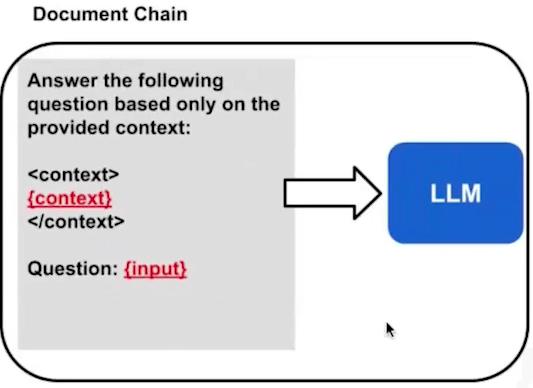

Our nect step is building a retriver chain tjhat contains:


*   The augmented prompt
    *   Now that the augmented prompt contains a template for the **context**

*   The LLM

*   The vector stor retriver


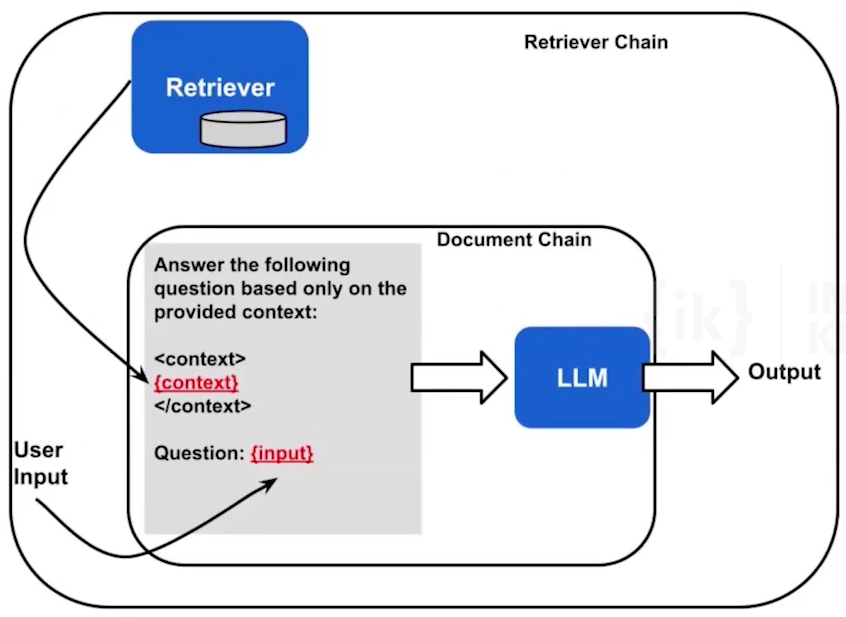

This setup enables the AI to provide accurate answers by first retrieving and then processing relevant documents.

In [39]:
# Invoking the retrieval chain to process the user's query.
# The query "what are some of the best shoes available?" is passed as input.
# The retrieval chain first fetches relevant product descriptions from the vector store,
# then processes them using the document chain to generate a meaningful LLM response.
retrieval_chain.invoke({"input": "what are some of the best shoes available?"})

{'input': 'what are some of the best shoes available?',
 'context': [Document(id='4aa30171-4d4a-4bd1-8ccc-a43dc2acfaa8', metadata={}, page_content="Title\nadidas Men's Predator 18+ FG Firm Ground Soccer Cleats\nDescription\nadidas Predator 18+ FG- Black 7.5"),
  Document(id='1cdf282e-8a02-42ca-a7a8-d53195009d69', metadata={}, page_content="Title\nPUMA Cali Sport Clean Women's Sneakers White Leather (37540701)"),
  Document(id='c8f15d7c-926b-4e29-87ca-8e174d56ad31', metadata={}, page_content="Title\nKenneth Cole REACTION Men's Crespo Loafer B Shoe, Cognac, 10 M US"),
  Document(id='45fbd7ec-01b4-4e36-b65b-36d1fd3095ef', metadata={}, page_content="The Remora Climbing Shoe is Mad Rock's do-it-all slipper for climbers who can't have separate shoes for boulders, sport routes, and gyms. With a moderately stiff, slightly downturned design, the Remora performs on any climb at steep to vertical")],
 'answer': "Based on the provided context, some of the best shoes available include:\n\n1. adidas

In [40]:
# Fetching the final answer from the retrieval chain by invoking it with a user query.
# The ['answer'] key extracts the final LLM-generated answer from the response dictionary.
resp = retrieval_chain.invoke({"input": "what are some of the best shoes available?"})['answer']
print(resp)

Based on the provided context, some of the best shoes available include:

1. adidas Men's Predator 18+ FG Firm Ground Soccer Cleats
2. PUMA Cali Sport Clean Women's Sneakers
3. Kenneth Cole REACTION Men's Crespo Loafer B Shoe
4. Mad Rock Remora Climbing Shoe

These options cater to various activities such as soccer, casual wear, formal occasions, and climbing.


Now, we got the answer! But, the formatting is not very good, right? Lets create a simple UI for our bot.

### STEP 4: Building a simple Gradio UI

Gradio is an open-source Python library that makes it easy to build interactive user interfaces for machine learning models, APIs, and data science workflows. It allows developers to create shareable web-based UIs with just a few lines of code.

To build the gradio app we'll utilize the following steps:

- Modularize the entire RAG pipeline using a single function
- Create the building blocks for the UI.
- Connect the UI with the function

In [41]:
# Function to process the user query and return formatted product names
def final_response(user_query):
    # Invoking the retrieval chain with the user's query to fetch relevant product information
    response = retrieval_chain.invoke({"input": user_query})['answer']

    # Creating a prompt to instruct the LLM to format the response properly
    # The prompt asks the LLM to extract only product names from the
    # retrieved response
    prompt = f"Format the responses properly in {response}. Just return the product names, no other text"

    # Sending the formatted prompt to the GPT-4o-mini model for processing
    openai_response = client.chat.completions.create(
        model='gpt-4o-mini',  # Using GPT-4o-mini model for response generation
        messages=[{'role': 'user', 'content': prompt}]  # Providing the prompt to the model
    )

    # Extracting and returning the LLM-generated response containing only the
    # product names
    return openai_response.choices[0].message.content


In [42]:
# Printing the final response
print(final_response("what are some of the best shoes available?"))

1. adidas Men's Predator 18+ FG Firm Ground Soccer Cleats  
2. PUMA Cali Sport Clean Women's Sneakers  
3. Kenneth Cole REACTION Men's Crespo Loafer B Shoe  
4. Mad Rock Remora Climbing Shoe  


In [43]:
# Importing the Gradio library to create a simple web-based user interface
import gradio as gr

# Creating the Gradio interface for the product recommendation system
app = gr.Interface(
    fn=final_response,        # The function that processes user input and returns recommendations
    inputs="text",            # Input component: a text box for users to enter their query
    outputs="text",           # Output component: a text box to display the AI-generated response
    title="Review Genie",     # The title of the web interface
    description="Type your question below to get the recommendations",# A brief description displayed to users
    theme="Ocean",
    allow_flagging="never"    # Disabling the flagging feature to remove the "Flag" button
)

# Launching the Gradio app to start the interface and make it accessible via web browser
app.launch()


/usr/local/lib/python3.11/dist-packages/gradio/interface.py:415: UserWarning: The `allow_flagging` parameter in `Interface` is deprecated.Use `flagging_mode` instead.
  warnings.warn(


It looks like you are running Gradio on a hosted a Jupyter notebook. For the Gradio app to work, sharing must be enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://65c9c212fd4a54e08b.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


### Next Steps for Experimentation

In the above demonstration, we have created a very basic GUI-based RAG app. Before our next class, you are urged to experiment the following

- Try asking 10-15 questions and check the accuracy of the response.
- What would be a strategy that you might follow to evaluate the app's overall responses?
- Ask a few out-of-the-box questions (like "What is the weather today in Seattle?")
- Try asking the same question multiple times with a different wording
- In the same chat history, ask questions which are related to the response that was just provided.
- Use a different dataset (perhaps in a different format like pdf) and see how the architecture might change.

<hr> <hr>